In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from math import sqrt
import datetime
import plotly.graph_objects as go
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
import xgboost as xgb
from sklearn.model_selection import train_test_split

import shap

We've now built our dataset in Data_prep, we can start focusing on analysis.

In [27]:
# read in the full data df
dtypes = {'start_station_id': str, 'end_station_id': str}

full_data = pd.read_csv('data/2023-citibike-full-data.csv', parse_dates=['started_at', 'ended_at'], dtype=dtypes)
# read in the daily data df
#daily_data = pd.read_csv('data/citibike-tripdata/citibike-tripdata-daily-counts.csv', parse_dates=['datetime'])


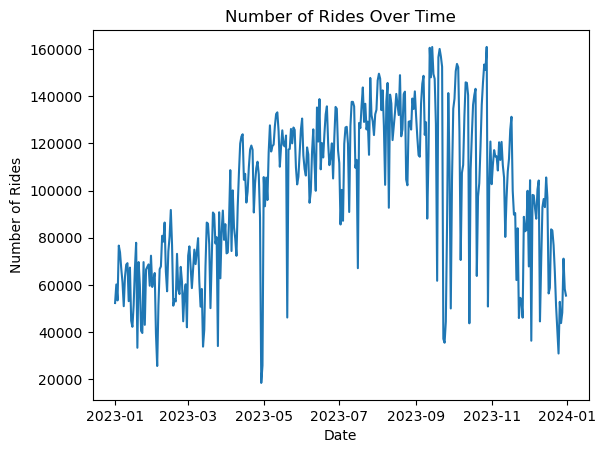

In [4]:
# now we can start to do some analysis
# we'll start with the daily data to get a baseline understanding of the data
# we'll start by looking at how the number of trips changes over our year of interest

# first we'll plot the number of trips over time
fig, ax = plt.subplots()
ax.plot(daily_data['datetime'], daily_data['total_rides'])
ax.set_title('Number of Rides Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Rides')
plt.show()

We see that there is definitely some trend in the data with number of rides dropping significantly in winter months, and with considerable variation day to day.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# we can now try to fit a model to this data to see if we can predict the number of rides
# we'll start with a simple linear regression model
# starting with a slightly more limited set of features
# print out the columns to see what we have to work with
print(daily_data.columns)
# convert the datetime values to a float so that we can use them in the model
daily_data['datetime'] = daily_data['datetime'].astype(int)


features = ['datetime', 'temp', 'feelslike', 'dew',
       'humidity', 'visibility', 'cloudcover', 'windspeed',
       'precip', 'SIR', 'Bridges_Tunnels', 'Access_A_Ride',
       'Metro_North', 'LIRR', 'Buses', 'Subways', 'weekday', 'holiday',
       'month', 'precip_d', 'cold_d', 'hot_d', 'Bridges_Tunnels_d',
       'Access_A_Ride_d', 'Metro_North_d', 'LIRR_d', 'Buses_d', 'Subways_d']
target = 'total_rides'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(daily_data[features], daily_data[target], test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error
rmse = sqrt(np.mean((y_pred - y_test) ** 2))
print('Root Mean Squared Error:', rmse)

# take a look at the coefficients
coefficients = pd.DataFrame({'feature': X_train.columns, 'coefficient': model.coef_})
print(coefficients)


NameError: name 'daily_data' is not defined

In [39]:
# we can now try addressing our larger dataset with rides for every day
# here instead of total rides we'll try to predict the duration of the rides
# we'll start with a simple linear regression model
# starting with a slightly more limited set of features

# convert the datetime values to a float so that we can use them in the model
full_data['started_at'] = full_data['started_at'].astype(int)

features = ['started_at', 
       'temp', 'feelslike', 'dew', 'humidity', 
       'weekday', 'holiday', 'month',
       'precip_d', 'cold_d', 'hot_d', 'night', 'station0', 'station1',
       'station2', 'station3', 'station4', 'station5', 'member', 'electric',
       'Bridges_Tunnels_d', 'Access_A_Ride_d', 'Metro_North_d', 'LIRR_d',
       'Buses_d', 'Subways_d', 'precip', 'SIR', 'Bridges_Tunnels', 'Access_A_Ride', 'Metro_North',
       'LIRR', 'Buses', 'Subways']
target = 'ride_duration'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_data[features], full_data[target], test_size=0.2, random_state=42)

# Create and fit the linear regression model
duration_model = LinearRegression()
duration_model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = duration_model.predict(X_test)

# Calculate the root mean squared error
rmse_linear_reg = sqrt(np.mean((y_pred - y_test) ** 2))
print('Root Mean Squared Error:', rmse)

# take a look at the coefficients
coefficients = pd.DataFrame({'feature': X_train.columns, 'coefficient': duration_model.coef_})
print(coefficients)


Root Mean Squared Error: inf
              feature   coefficient
0          started_at  1.687635e-15
1                temp  1.583637e+00
2           feelslike  1.743445e+00
3                 dew  7.151965e-01
4            humidity -1.531234e+00
5             weekday  4.134574e-03
6             holiday -4.601747e-03
7               month -6.100726e-02
8            precip_d  4.755260e-03
9              cold_d -1.169852e-02
10              hot_d  0.000000e+00
11              night -9.457296e-05
12           station0  4.733159e-04
13           station1 -2.053888e-04
14           station2 -6.582347e-04
15           station3  1.268426e-03
16           station4 -6.005973e-04
17           station5 -2.775212e-04
18             member -2.076366e-03
19           electric  7.568909e-04
20  Bridges_Tunnels_d  1.196545e-03
21    Access_A_Ride_d -5.529441e-03
22      Metro_North_d  1.047483e-03
23             LIRR_d -5.182198e-04
24            Buses_d  1.006300e-03
25          Subways_d  3.705019e-03

In [40]:
# let's try a random forest model to see if we can get a better performance
# Create and fit the random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred_rf = rf_model.predict(X_test)
rmse_rf = sqrt(mean_squared_error(y_test, y_pred_rf))

print('Root Mean Squared Error:', rmse_rf)

Root Mean Squared Error: 1124.778614565563


The Random Forest approach seems to perform a little bit worse. Let's try introducing slightly more complexity to our feature space and then giving lasso regression a try.

In [41]:
# trying a lasso regression model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_data[features], full_data[target], test_size=0.2, random_state=42)

# Create and fit the lasso regression model
# search over alpha values to find the best one
alpha = 0.1
lasso_cv = LassoCV(alphas=[alpha], cv=5, random_state=42, max_iter=10000, tol=0.0001)
lasso_cv.fit(X_train, y_train)

# Predict and calculate RMSE
y_pred_lasso = lasso_cv.predict(X_test)
rmse_lasso = sqrt(mean_squared_error(y_test, y_pred_lasso))

print('Root Mean Squared Error:', rmse_lasso)

Root Mean Squared Error: 983.195195134147


/Users/fordshaper/miniforge3/envs/cs1430/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.425e+11, tolerance: 1.351e+08
  model = cd_fast.enet_coordinate_descent(


In [32]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 6,  # maximum depth of a tree
    'eta': 0.3,  # the learning rate
    'objective': 'reg:squarederror',  # regression task with squared loss
    'eval_metric': 'rmse',  # using RMSE as the evaluation metric
}
num_boost_round = 100  # number of trees to build

bst = xgb.train(params, dtrain, num_boost_round, evals=[(dtest, 'test')], early_stopping_rounds=10)

y_pred = bst.predict(dtest)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse_xgb))


[0]	test-rmse:994.27258
[1]	test-rmse:987.91170
[2]	test-rmse:984.69043
[3]	test-rmse:983.00186
[4]	test-rmse:981.98929
[5]	test-rmse:981.44754
[6]	test-rmse:981.14472
[7]	test-rmse:980.98286
[8]	test-rmse:980.79892
[9]	test-rmse:980.67241
[10]	test-rmse:980.56877
[11]	test-rmse:980.52001
[12]	test-rmse:980.42164
[13]	test-rmse:980.42030
[14]	test-rmse:980.40604
[15]	test-rmse:980.40013
[16]	test-rmse:980.34985
[17]	test-rmse:980.38128
[18]	test-rmse:980.35058
[19]	test-rmse:980.34178
[20]	test-rmse:980.31742
[21]	test-rmse:980.35292
[22]	test-rmse:980.38062
[23]	test-rmse:980.36923
[24]	test-rmse:980.33108
[25]	test-rmse:980.32650
[26]	test-rmse:980.29452
[27]	test-rmse:980.30773
[28]	test-rmse:980.30714
[29]	test-rmse:980.33220
[30]	test-rmse:980.29574
[31]	test-rmse:980.29346
[32]	test-rmse:980.28479
[33]	test-rmse:980.28457
[34]	test-rmse:980.27121
[35]	test-rmse:980.27205
[36]	test-rmse:980.28052
[37]	test-rmse:980.29045
[38]	test-rmse:980.28345
[39]	test-rmse:980.28911
[40]	test-

In [45]:
# It seems that the model is struggling to predict the longer rides
# Lets try a log transformation to see if that helps

full_data['started_at'] = full_data['started_at'].astype(int)
# Apply log transformation to the ride_duration to normalize distribution
full_data['log_ride_duration'] = np.log(full_data['ride_duration'] + 1)  # Adding 1 to avoid log(0)

log_features = [
    'started_at', 'temp', 'feelslike', 'dew', 'humidity',
    'weekday', 'holiday', 'month',
    'precip_d', 'cold_d', 'hot_d', 'night', 'station0', 'station1',
    'station2', 'station3', 'station4', 'station5', 'member', 'electric',
    'Bridges_Tunnels_d', 'Access_A_Ride_d', 'Metro_North_d', 'LIRR_d',
    'Buses_d', 'Subways_d', 'precip', 'SIR', 'Bridges_Tunnels', 'Access_A_Ride', 'Metro_North',
    'LIRR', 'Buses', 'Subways'
]
log_target = 'log_ride_duration'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(full_data[log_features], full_data[log_target], test_size=0.2, random_state=42)

# first a linear regression model
log_duration_model = LinearRegression()
log_duration_model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = log_duration_model.predict(X_test)

# convert the predicted values back to the original scale 
y_pred = np.exp(y_pred) - 1
y_test = np.exp(y_test) - 1

# Calculate the root mean squared error
rmse_log_linreg = sqrt(np.mean((y_pred - y_test) ** 2))
print('Linear Regression Root Mean Squared Error:', rmse_log_linreg)

# split the data into training and testing sets again
X_train, X_test, y_train, y_test = train_test_split(full_data[log_features], full_data[log_target], test_size=0.2, random_state=42)

# Prepare data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 6,  # maximum depth of a tree
    'eta': 0.3,  # the learning rate
    'objective': 'reg:squarederror',  # regression task with squared loss
    'eval_metric': 'rmse',  # using RMSE as the evaluation metric
}
num_boost_round = 100  # number of trees to build


# train the model
log_bst = xgb.train(params, dtrain, num_boost_round, evals=[(dtest, 'test')], early_stopping_rounds=10)

# Predict and calculate RMSE
y_pred = log_bst.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

# calculate RMSE for the original ride duration
# ensure that there are no infinite values
y_pred = np.exp(y_pred) - 1
y_test = np.exp(y_test) - 1

# Calculate the root mean squared error
rmse = sqrt(np.mean((y_pred - y_test) ** 2))
print("RMSE: %f" % (rmse))


Linear Regression Root Mean Squared Error: 1033.36857323087
[0]	test-rmse:0.82443
[1]	test-rmse:0.81745
[2]	test-rmse:0.81379
[3]	test-rmse:0.81189
[4]	test-rmse:0.81083
[5]	test-rmse:0.81022
[6]	test-rmse:0.80987
[7]	test-rmse:0.80962
[8]	test-rmse:0.80941
[9]	test-rmse:0.80925
[10]	test-rmse:0.80919
[11]	test-rmse:0.80910
[12]	test-rmse:0.80902
[13]	test-rmse:0.80888
[14]	test-rmse:0.80886
[15]	test-rmse:0.80877
[16]	test-rmse:0.80876
[17]	test-rmse:0.80872
[18]	test-rmse:0.80868
[19]	test-rmse:0.80866
[20]	test-rmse:0.80861
[21]	test-rmse:0.80859
[22]	test-rmse:0.80857
[23]	test-rmse:0.80856
[24]	test-rmse:0.80856
[25]	test-rmse:0.80851
[26]	test-rmse:0.80850
[27]	test-rmse:0.80850
[28]	test-rmse:0.80848
[29]	test-rmse:0.80848
[30]	test-rmse:0.80847
[31]	test-rmse:0.80847
[32]	test-rmse:0.80845
[33]	test-rmse:0.80844
[34]	test-rmse:0.80842
[35]	test-rmse:0.80839
[36]	test-rmse:0.80837
[37]	test-rmse:0.80836
[38]	test-rmse:0.80836
[39]	test-rmse:0.80835
[40]	test-rmse:0.80834
[41]	te

In [46]:
# make a table of the RMSE values
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Lasso Regression', 'XGBoost', 'Linear Regression (Log Transformed)',
                'XGBoost (Log Transformed)'], 
    'RMSE': [rmse_linear_reg, rmse_rf, rmse_lasso, rmse_xgb, rmse_log_linreg, rmse]
})
print(results)


                                 Model         RMSE
0                    Linear Regression  1003.032927
1                        Random Forest  1124.778615
2                     Lasso Regression   983.195195
3                              XGBoost   980.316916
4  Linear Regression (Log Transformed)  1033.368573
5            XGBoost (Log Transformed)  1009.985105


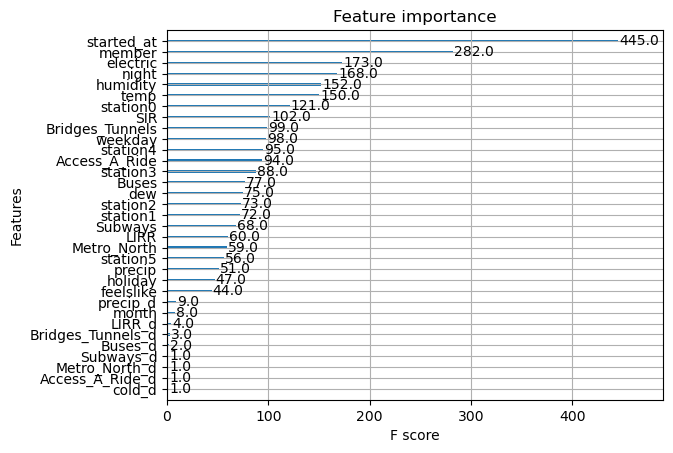

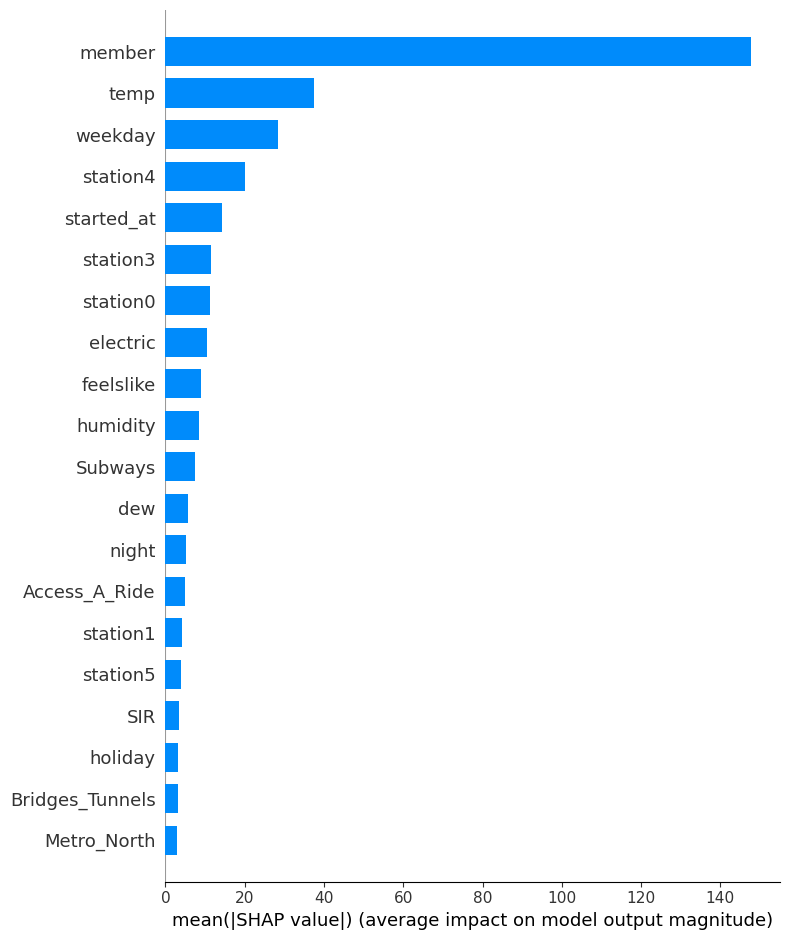

In [47]:
# now that we have a model that we're happy with lets take a look at the feature importance

xgb.plot_importance(bst)
plt.show()

# Calculate SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

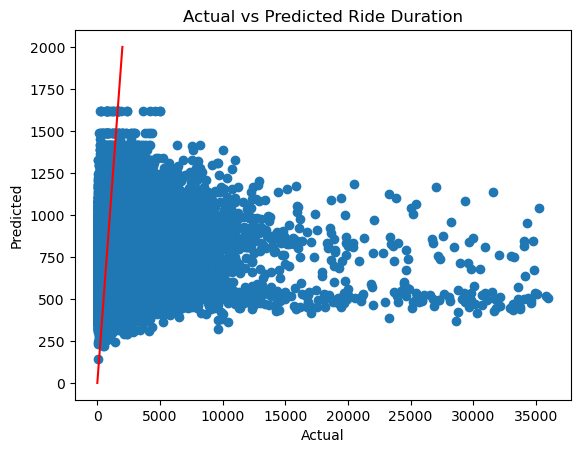

In [52]:
# lets take a look at the actual vs predicted values
# include a line that shows where the actual and predicted values are equal
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)

ax.set_title('Actual vs Predicted Ride Duration')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.plot([0, 2000], [0, 2000], color='red')
plt.show()





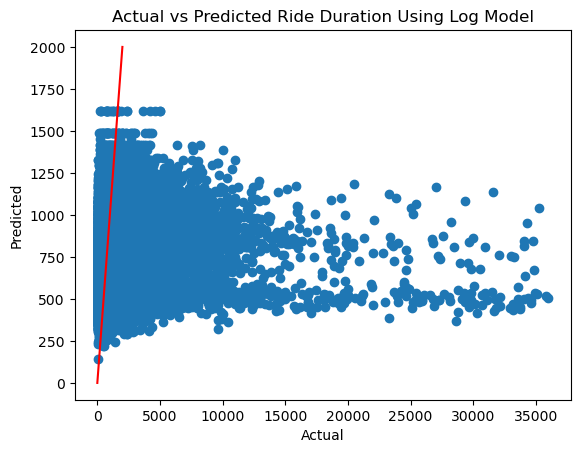

In [53]:
# use the model trained with log transformed data to predict the log transformed ride duration
# then transform the predictions back to the original scale
y_pred = log_bst.predict(dtest)
y_pred = np.exp(y_pred) - 1

# Plot actual vs predicted values
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)

ax.set_title('Actual vs Predicted Ride Duration Using Log Model')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.plot([0, 2000], [0, 2000], color='red')
plt.show()
